In [1]:
pip install scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 MB 75.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearnex import patch_sklearn
patch_sklearn()

data = np.load("results/predictions_depth_data.npz",  allow_pickle=True)

pred_grasps_cam = data["pred_grasps_cam"]
scores = data["scores"]
contact_pts = data["contact_pts"]

def distance_by_translation_point(points, ref_point):
    """Calculate Euclidean distance from a set of points to a reference point."""
    return np.linalg.norm(points - ref_point, axis=1)


def farthest_points(points, n_samples, distance_metric, return_center_indexes=False):
    """Farthest Point Sampling (FPS) implementation.

    Args:
        points (np.ndarray): Nx3 array of points.
        n_samples (int): Number of points to sample.
        distance_metric (function): A function that calculates the distance between points.
        return_center_indexes (bool): Whether to return the indices of the selected points.

    Returns:
        np.ndarray: If return_center_indexes is True, returns the indices of the selected points.
                      Otherwise, returns the selected points themselves.
    """
    if len(points) <= n_samples: #Return all points for trivial reasons
        if return_center_indexes:
            return np.arange(len(points)) # Return all indexes if return_center_indexes
        return points  # Return the points themselves

    # Start with random choice
    center_ids = [np.random.randint(len(points))] #initial point
    center = points[center_ids[0]] #initialise the start point
    center_pts = np.zeros((n_samples, points.shape[-1]),dtype=np.float32) #initialise points
    center_pts[0,:] = center #initialise point at start

    for i in range(1, n_samples): #Find furthest points for each sample
        dists = distance_metric(points, center) #calc dist from points to initial point

        farthest_id = np.argmax(dists) #Find the furthest distance from all points

        center = points[farthest_id] #re-center

        center_ids.append(farthest_id) #save furthest distance position
        center_pts[i,:] = center #save point to pts array

    #Now either return the id or point
    if return_center_indexes:
        return center_ids

    return center_pts #else pts

def select_grasps(grasp_positions, angles, approaches, scores, score_threshold):
    """
    Filter grasp predictions based on their scores.
    """
    valid_indices = np.where(scores > score_threshold)[0]
    return grasp_positions[valid_indices], angles[valid_indices], approaches[valid_indices], scores[valid_indices]


def cluster_grasps(grasp_positions, n_clusters, clustering_method = 'KMeans', eps = 0.05, min_samples = 5):
    """
    Clusters grasp positions using the selected method (K-Means or DBSCAN).
    """
    if clustering_method == 'KMeans':

        kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init = 'auto')  # Specify clusters for K-Means and remove warning
        cluster_labels = kmeans.fit_predict(grasp_positions)
        cluster_centers = kmeans.cluster_centers_

    elif clustering_method == 'DBSCAN':

        dbscan = DBSCAN(eps=eps, min_samples=min_samples) #Density Based Clusters, specify eps range
        cluster_labels = dbscan.fit_predict(grasp_positions)
        n_clusters = len(set(cluster_labels)) # number of clusters
        if -1 in cluster_labels: #Remove outliers if exists
            n_clusters -=1 #Outliers are assigned the label of -1, ignore these when averaging

        cluster_centers = np.empty((n_clusters, grasp_positions.shape[1])) #initialise to store cluster centres
        for i in range(n_clusters): # take the average of all coordinates
            cluster_coords = grasp_positions[cluster_labels==i]
            cluster_centers[i,:] = np.mean(cluster_coords, axis=0)

    return cluster_labels, cluster_centers #Return centres

def select_representative_grasps(grasp_positions, angles, approaches, scores, cluster_labels, cluster_centers):
    """
    Selects a representative grasp from each cluster (closest to the cluster center).
    """
    selected_grasps = []
    selected_angles = []
    selected_approaches = []
    selected_scores = []

    for cluster_id in range(len(cluster_centers)): #Iterate through the centres
        # Get the grasp positions belonging to the current cluster
        cluster_grasps = grasp_positions[cluster_labels == cluster_id]

        # If the cluster is empty (very unlikely, but handle it), skip this cluster
        if len(cluster_grasps) == 0:
            continue #Ignore iteration

        # Find the grasp position closest to the cluster center using NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_grasps)
        distances, indices = nbrs.kneighbors(cluster_centers[cluster_id].reshape(1, -1)) #Reshape to the right format

        # Select the grasp that is closest to the cluster center
        closest_idx = indices[0][0]  # Index of the closest grasp in cluster_grasps
        cluster_idxs = np.where(cluster_labels==cluster_id)[0] # find positions in total grasps
        true_idx = cluster_idxs[closest_idx] # then retrieve their true positions in the index
        # Append the selected grasp
        selected_grasps.append(grasp_positions[true_idx])
        selected_angles.append(angles[true_idx])
        selected_approaches.append(approaches[true_idx])
        selected_scores.append(scores[true_idx]) #Return the final best scores to test later

    return np.array(selected_grasps), np.array(selected_angles), np.array(selected_approaches), np.array(selected_scores) #Return arrays

def farthest_point_sampling(grasp_positions, angles, approaches, scores, num_grasps, translateDistance):
        """
        Performs farthest point sampling (FPS) to select a diverse subset of grasps.

        :param grasp_positions (np.ndarray): Nx3 array of grasp positions
        :param num_grasps (int): Number of grasps to select

        :returns: Indices of selected grasp positions
        """
        #Calculate distance from the translation
        if len(grasp_positions) <= num_grasps: # return the whole position if they don't have enough grasp to downsample
            return grasp_positions, angles, approaches, scores

        # farthest_points function is called as before. To use the custom point translator, this method is implemented
        selected_grasps_indexes = farthest_points(grasp_positions[:,:3], num_grasps, translateDistance, return_center_indexes = False) #return the grasp positions by translation indexes

        return grasp_positions[selected_grasps_indexes], angles[selected_grasps_indexes], approaches[selected_grasps_indexes], scores[selected_grasps_indexes]

def diversified_grasp_selector(grasp_positions, angles, approaches, scores, top_n, score_threshold, cluster_num, clusteringMethod, translationDistance, fps_number, eps_dbscan, min_samples_dbscan):
    #1 - select grasps with a good score
    (grasp_positions_good, angles_good,
    approaches_good, scores_good) = select_grasps(grasp_positions, angles,
                                                    approaches, scores,
                                                    score_threshold)

    # 2 - Cluster grasps
    cluster_labels, cluster_centers = cluster_grasps(grasp_positions_good, cluster_num, clusteringMethod, eps_dbscan, min_samples_dbscan)

    #3 - Select a good representative
    selected_grasps, selected_angles, selected_approaches, selected_scores = select_representative_grasps(grasp_positions_good, angles_good, approaches_good, scores_good, cluster_labels, cluster_centers)

    #4 - Use furthest point Sampling
    selected_grasps_div, selected_angles_div, selected_approaches_div, selected_scores_div = farthest_point_sampling(selected_grasps, selected_angles, selected_approaches, selected_scores, fps_number, translationDistance)

    #5 - Return top N
    return selected_grasps_div[:top_n], selected_angles_div[:top_n], selected_approaches_div[:top_n], selected_scores_div[:top_n]

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
pred_grasps_cam = np.array(list(pred_grasps_cam.item().values()))[0][:, :-1, :]

In [43]:
#Check dimensions as well to get the centre positions
if len(pred_grasps_cam.shape) > 3:
    grasp_positions = pred_grasps_cam[0,:,:3,3] #For a full batch implementation
else:
    grasp_positions = pred_grasps_cam[:,:3,3] #If this is a single batch implementation

angles = np.arctan2(pred_grasps_cam[:,1,0], pred_grasps_cam[:,0,0])

approaches = contact_pts #In this implementation the approaches and contact pts are equal.
"""
    diversified_grasp_selector(grasp_positions, angles, approaches, scores, top_n, score_threshold, cluster_num, clusteringMethod, translationDistance, fps_number):
"""
# Set parameters for the diversified grasp selector
top_n = 4 #Number of desired points to be returned
score_threshold = 0.7
cluster_num = 10
clusteringMethod = 'KMeans'

#Note, there was some strange interaction between translate distance, therefore
translateDistance = distance_by_translation_point

fps_number = 12 # this is a high number to then perform a final downsample
eps_dbscan = 0.05 # tune parameters for DBSCAN
min_samples_dbscan = 5  # Minimum number of samples


# Run the diversified grasp selector
selected_grasps, selected_angles, selected_approaches, selected_scores = diversified_grasp_selector(
        grasp_positions, angles, approaches, scores, top_n, score_threshold, cluster_num, clusteringMethod, translateDistance, fps_number, eps_dbscan, min_samples_dbscan) #The final three parameters need tuning

# Print or use the selected grasps
print("Selected Grasps:")
for i in range(len(selected_grasps)):
    print(f"Grasp {i+1}: Position={selected_grasps[i]}, Angle={selected_angles[i]}, Score={selected_scores[i]}")

TypeError: '>' not supported between instances of 'dict' and 'float'

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
camera started
Realsense camera started
Depth data saved to depth_data.npz
Vertices captured in 0.05 seconds
(307200, 3)
Depth data saved to depth_data.npz
Vertices captured in 0.03 seconds
(307200, 3)
Depth data saved to depth_data.npz
Vertices captured in 0.03 seconds
(307200, 3)
[[-0.55437154 -0.43839356  1.074     ]
 [-0.55260956 -0.43839356  1.074     ]
 [-0.5518735  -0.43921     1.0760001 ]
 ...
 [ 0.2712968   0.19387573  0.513     ]
 [ 0.2721384   0.19387573  0.513     ]
 [ 0.27298     0.19387573  0.513     ]]


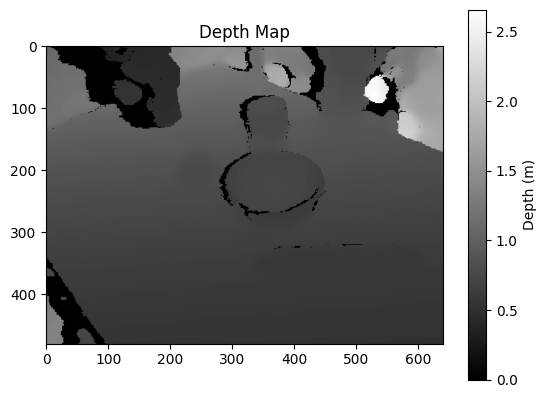

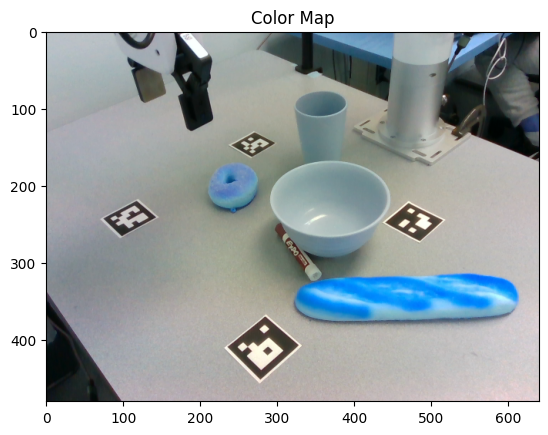

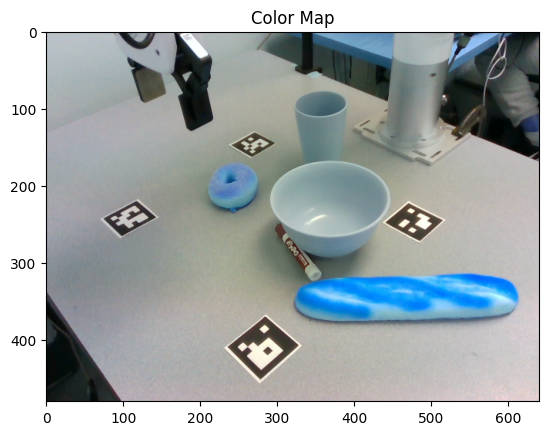

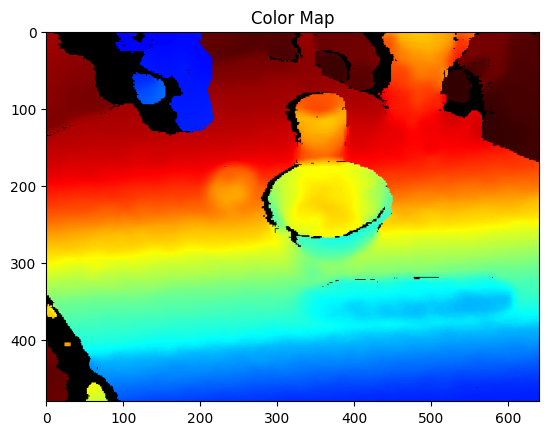

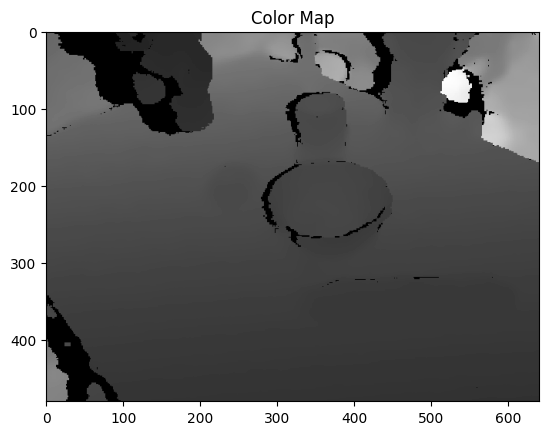

In [ ]:
from homography import HomographyManager # Import HomographyManager
import sys
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import time

homography_manager = HomographyManager()
try:
    homography_manager.start_camera()
except Exception as e:
    print(f"Error starting RealSense camera: {e}")
    # Handle the error appropriately, e.g., continue without homography if needed
    sys.exit("RealSense camera failed to start, exiting.") # Exit if RealSense camera fails to start

homography_manager.fetch_3D_scene()

# Load the saved data
data = np.load("depth_data.npz")
depth_image = data["depth"]
K = data["K"]
color_image = data["color"]
#c1 = data["c1"]
#d1 = data["d1"]
#df1 = data["df1"]

# Show depth map in a separate window
plt.figure()
plt.imshow(depth_image, cmap="gray")
plt.colorbar(label="Depth (m)")
plt.title("Depth Map")
plt.show(block=False)  # Keep the window open
#time.sleep(10)
plt.figure()
plt.imshow(color_image, cmap="gray")
plt.title("Color Map")
plt.show(block=False)

plt.figure()
plt.imshow(c1, cmap="gray")
plt.title("Color Map")
plt.show(block=False)

plt.figure()
plt.imshow(d1, cmap="gray")
plt.title("Color Map")
plt.show(block=False)

plt.figure()
plt.imshow(df1, cmap="gray")
plt.title("Color Map")
plt.show(block=False)

# Convert depth map to point cloud
h, w = depth_image.shape
fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]

points = []
for v in range(h):
    for u in range(w):
        z = depth_image[v, u]
        if z > 0:  # Ignore invalid depth values
            x = (u - cx) * z / fx
            y = (v - cy) * z / fy
            points.append([x, y, z])

# Convert to Open3D format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.array(points))

# Open point cloud visualization in a separate window
o3d.visualization.draw_geometries([pcd])


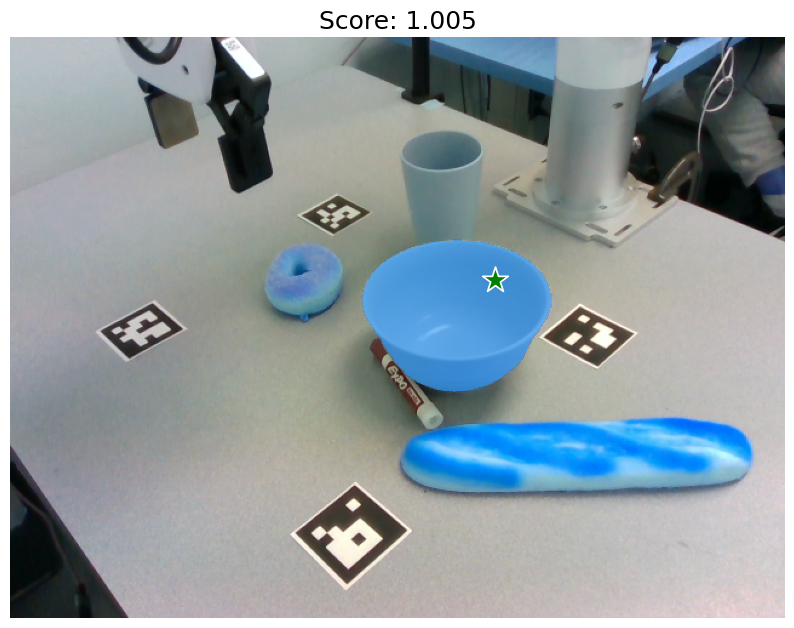

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/u-ril/contact_graspnet/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

image = color_image
predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[400, 200]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask_index = np.argmax(scores)
best_mask = masks[best_mask_index]
best_score = scores[best_mask_index]
best_logit = logits[best_mask_index]

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(best_mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Score: {best_score:.3f}", fontsize=18)
plt.axis('off')
plt.show()  
  

In [4]:
best_mask = best_mask.astype(np.int32)
np.savez('depth_data.npz', depth=depth_image, K=K, segmap =best_mask, color=color_image)

In [ ]:
import torch
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

sam_checkpoint = "/home/u-ril/contact_graspnet/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

image = color_image
predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[400, 200]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask_index = np.argmax(scores)
best_mask = masks[best_mask_index]

best_mask = best_mask.astype(np.int32)
np.savez('depth_data.npz', depth=depth_image, K=K, segmap =best_mask, color=color_image)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

sam_checkpoint = "/home/u-ril/contact_graspnet/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

image = color_image
predictor = SamPredictor(sam)
predictor.set_image(image)

input_point = np.array([[400, 200]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

best_mask_index = np.argmax(scores)
best_mask = masks[best_mask_index]

best_mask = best_mask.astype(np.int32)
np.savez('depth_data.npz', depth=depth_image, K=K, segmap =best_mask, color=color_image)

/home/u-ril/miniconda3/envs/tracey/lib/python3.9/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
#import argparse
import ast
import torch
from PIL import Image
from fastsam import FastSAM, FastSAMPrompt


def run_fastsam_inference(
    model_path="./FastSAM-s.pt",
    input_img=None,
    imgsz=1024,
    iou=0.9,
    conf=0.4,
    point_prompt="[[0,0]]",
    point_label="[1,0]",
    better_quality=False,
    device=None,
    retina=True,
    withContours=False,
):
    """Runs FastSAM inference on a given image.

    Args:
        model_path (str): Path to the FastSAM model.
        input_img: The input image.
        imgsz (int, optional): Image size. Defaults to 1024.
        iou (float, optional): IOU threshold. Defaults to 0.9.
        conf (float, optional): Confidence threshold. Defaults to 0.4.
        output_path (str, optional): Path to save output. Defaults to "./output/".
        point_prompt (str, optional): Point prompt as a string (e.g., "[[350,300]]"). Defaults to "[[0,0]]".
        point_label (str, optional): Point labels (e.g., "[1,0]"). Defaults to "[0]".
        better_quality (bool, optional): Improve quality using morphologyEx. Defaults to False.
        device (str, optional): Device to use ("cuda" or "cpu"). Defaults to auto-selection.
        retina (bool, optional): Use high-resolution segmentation masks. Defaults to True.
        withContours (bool, optional): Draw mask contours. Defaults to False.

    Returns:
        str: Path to the saved segmented image.
    """

    # Auto-detect device if not provided
    if device is None:
        device = torch.device(
            "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        )

    # Load model
    model = FastSAM(model_path)

    # Convert string inputs to actual Python lists
    point_prompt = ast.literal_eval(point_prompt)
    point_label = ast.literal_eval(point_label)

    # Run inference
    results = model(
        input_img,
        device=device,
        retina_masks=retina,
        imgsz=imgsz,
        conf=conf,
        iou=iou,
    )

    # Process prompts
    prompt_process = FastSAMPrompt(input_img, results, device=device)
    
    if point_prompt[0] != [0, 0]:
        ann = prompt_process.point_prompt(points=point_prompt, pointlabel=point_label)
    else:
        print("invalid segmentation prompt")

    # Get the output image (without the points)
    result = prompt_process.plot_to_result(
        annotations=ann,
        points=None,  # Ensure points are NOT plotted
        point_label=point_label,
        withContours=withContours,
        better_quality=better_quality,
    )
           
    return result, ann.reshape(ann.shape[1], ann.shape[2])



In [8]:
ann = ann.reshape(ann.shape[1], ann.shape[2])
print(ann.shape)  # This should print (h, w)

(480, 640)



0: 768x1024 35 objects, 3.3ms
Speed: 1.9ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


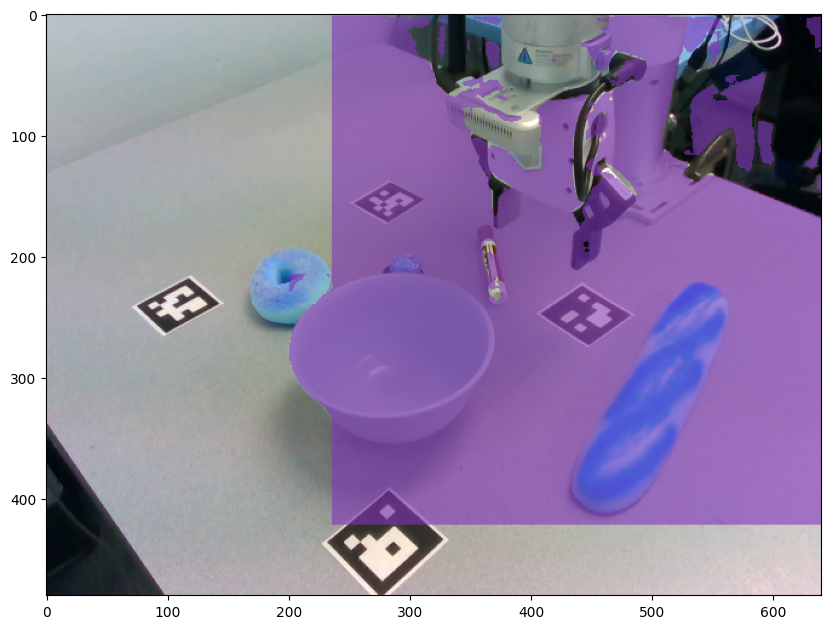

TypeError: Invalid shape (1, 480, 640) for image data

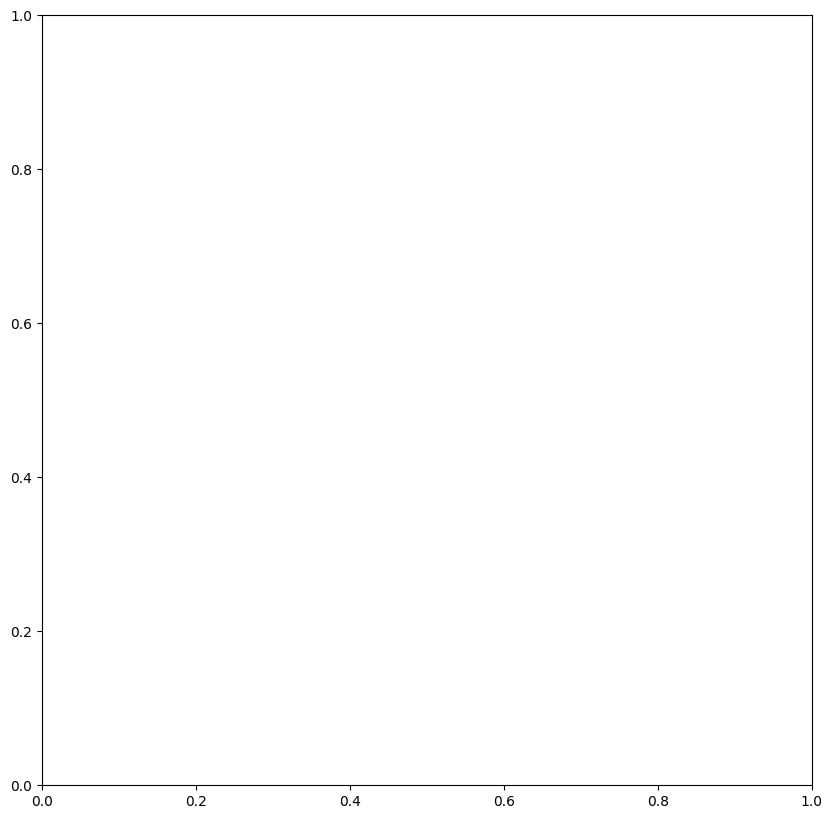

In [ ]:
result, ann = run_fastsam_inference(
            model_path="./FastSAM-s.pt",
            input_img=color_image,
            imgsz=1024,
            iou=0.9,
            conf=0.4,
            point_prompt="[[300,300]]",
            point_label="[1,0]",
            better_quality=False,
            device=None,
            retina=True,
            withContours=False,
        )


plt.figure(figsize=(10,10))
plt.imshow(result)
plt.axis('on')
plt.show()


print(ann)

In [9]:

np.savez('depth_data.npz', depth=depth_image, K=K, segmap =ann, color=color_image)

camera started
Realsense camera started
Depth data saved to depth_data.npz
Vertices captured in 0.01 seconds
(307200, 3)
Depth data saved to depth_data.npz
Vertices captured in 0.01 seconds
(307200, 3)
Depth data saved to depth_data.npz
Vertices captured in 0.01 seconds
(307200, 3)



0: 768x1024 38 objects, 3.2ms
Speed: 1.6ms preprocess, 3.2ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)


[[   -0.56211    -0.44452       1.089]
 [   -0.56033    -0.44452       1.089]
 [   -0.55957    -0.44533       1.091]
 ...
 [    0.27077      0.1935       0.512]
 [    0.27161      0.1935       0.512]
 [    0.27245      0.1935       0.512]]


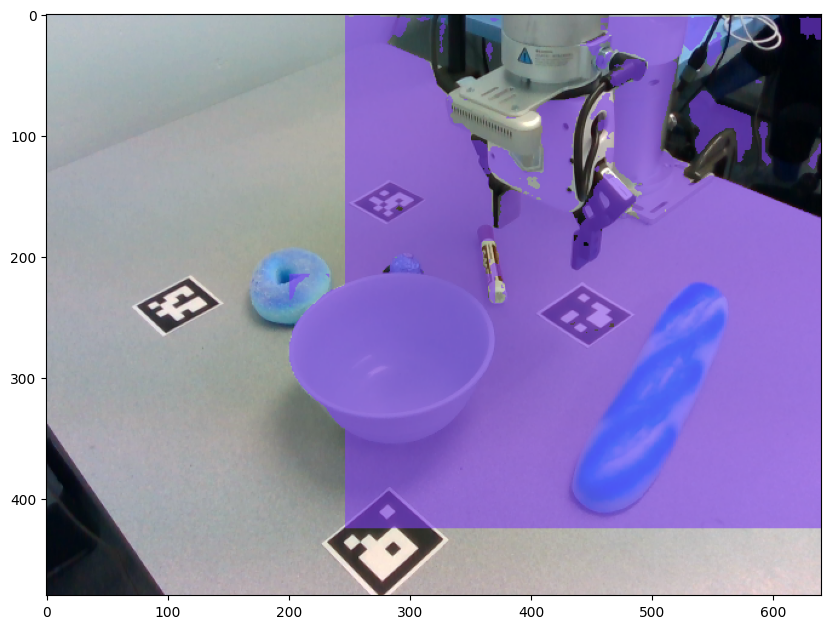

In [10]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from SAMInference import run_fastsam_inference
from homography import HomographyManager # Import HomographyManager

homography_manager = HomographyManager()
try:
    homography_manager.start_camera()
except Exception as e:
    print(f"Error starting RealSense camera: {e}")
    # Handle the error appropriately, e.g., continue without homography if needed
    sys.exit("RealSense camera failed to start, exiting.") # Exit if RealSense camera fails to start

homography_manager.fetch_3D_scene()

# Load the saved data
data = np.load("depth_data.npz")
depth_image = data["depth"]
K = data["K"]
color_image = data["color"]
result = run_fastsam_inference(
            model_path="./FastSAM-s.pt",
            input_img=color_image,
            imgsz=1024,
            iou=0.9,
            conf=0.4,
            point_prompt="[[300,300]]",
            point_label="[1,0]",
            better_quality=False,
            device=None,
            retina=True,
            withContours=False,
        )

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.axis('on')
plt.show()  

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from SAMInference import run_fastsam_inference
from homography import HomographyManager # Import HomographyManager

homography_manager = HomographyManager()
try:
    homography_manager.start_camera()
except Exception as e:
    print(f"Error starting RealSense camera: {e}")
    # Handle the error appropriately, e.g., continue without homography if needed
    sys.exit("RealSense camera failed to start, exiting.") # Exit if RealSense camera fails to start

homography_manager.fetch_3D_scene()

# Load the saved data
data = np.load("depth_data.npz")
depth_image = data["depth"]
K = data["K"]
color_image = data["color"]
result = run_fastsam_inference(
            model_path="./FastSAM-s.pt",
            input_img=color_image,
            imgsz=1024,
            iou=0.9,
            conf=0.4,
            point_prompt="[[330,330]]",
            point_label="[1,0]",
            better_quality=False,
            device=None,
            retina=True,
            withContours=False,
        )

segmented = result.astype(np.int32)
np.savez('depth_data.npz', depth=depth_image, K=K, segmap =segmented, color=color_image)

camera started
Realsense camera started



0: 768x1024 36 objects, 25.6ms
Speed: 4.6ms preprocess, 25.6ms inference, 67.5ms postprocess per image at shape (1, 3, 1024, 1024)


Depth data saved to depth_data.npz
Vertices captured in 0.82 seconds
(307200, 3)



0: 768x1024 35 objects, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)


Depth data saved to depth_data.npz
Vertices captured in 0.2 seconds
(307200, 3)



0: 768x1024 35 objects, 3.1ms
Speed: 1.7ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


[[   -0.55437    -0.43839       1.074]
 [   -0.55261    -0.43839       1.074]
 [   -0.55187    -0.43921       1.076]
 ...
 [     0.2713     0.19388       0.513]
 [    0.27214     0.19388       0.513]
 [    0.27298     0.19388       0.513]]


In [3]:
depth_image.shape

(480, 640)